**Experiment Details**:

52146 - 2 training sims, 1000 iterations, not so good for the other training sim, struggles to converge.

96778 - all sims but too slow, 10 batch time, 6 batch size, 7 sims per batch, 60 epochs, 500 iters

Next - reduce niters per epoch and reduce sims per batch to aggregate.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import pandas as pd

In [3]:
import re
import os
import time

In [4]:
import matplotlib.pyplot as plt
import argparse

In [5]:
# SPECIFY ARGS
# Generative model for noisy data based on ODE
parser = argparse.ArgumentParser('PNODE')

# parser.add_argument('-n',  type=int, default=1, help="Size of the dataset")
# parser.add_argument('-n',  type=int, default=100, help="Size of the dataset")

parser.add_argument('--niters', type=int, default=200)
parser.add_argument('--lr',  type=float, default=1e-3, help="Starting learning rate.")
parser.add_argument('-bs', '--batch-size', type=int, default=6)
parser.add_argument('-bt', '--batch-time', type=int, default=10)
parser.add_argument('-nspb', '--nsims_per_batch', type=int, default=5)
parser.add_argument('-epch', '--nepochs', type=int, default=60)


parser.add_argument('--save', type=str, default='experiments/', help="Path for save checkpoints")
parser.add_argument('--load', type=str, default=None, help="ID of the experiment to load for evaluation. If None, run a new experiment.")
parser.add_argument('-r', '--random-seed', type=int, default=1123, help="Random_seed")


parser.add_argument('--pnode', 
                    action='store_false', 
                    help="RUN parameterized neural ode")
parser.add_argument('--node-layers', 
                    type=int, 
                    default=2, 
                    help="number of layers in NODE")

parser.add_argument('-u', '--units', 
                    type=int, 
                    default=100, 
                    help="Number of units per layer in ODE func")

# parser.add_argument('--normalize', type=bool, default=True)

parser.add_argument('-ds',
                    type=int,
                    default=4,
                    help="Coarsening factor for position angles")

args = parser.parse_args(args=())

In [6]:
vars(args)

{'niters': 200,
 'lr': 0.001,
 'batch_size': 6,
 'batch_time': 10,
 'nsims_per_batch': 5,
 'nepochs': 60,
 'save': 'experiments/',
 'load': None,
 'random_seed': 1123,
 'pnode': True,
 'node_layers': 2,
 'units': 100,
 'ds': 4}

In [7]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from random import SystemRandom

In [8]:
%matplotlib inline

In [9]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
# !pip install --user -q torchdiffeq

In [12]:
adjoint=True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import edge_utils as edut
import node_1d_utils as nut

In [15]:
theta_s_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360
theta_e_2161 = np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [16]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)
# crude downsample for now
ed_2161 = ed_2161[:, ::args.ds, :]

In [17]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 40, 278)

In [18]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161 * args.ds)[::args.ds]
theta_grid

array([-31.        , -28.1572327 , -25.31446541, -22.47169811,
       -19.62893082, -16.78616352, -13.94339623, -11.10062893,
        -8.25786164,  -5.41509434,  -2.57232704,   0.27044025,
         3.11320755,   5.95597484,   8.79874214,  11.64150943,
        14.48427673,  17.32704403,  20.16981132,  23.01257862,
        25.85534591,  28.69811321,  31.5408805 ,  34.3836478 ,
        37.22641509,  40.06918239,  42.91194969,  45.75471698,
        48.59748428,  51.44025157,  54.28301887,  57.12578616,
        59.96855346,  62.81132075,  65.65408805,  68.49685535,
        71.33962264,  74.18238994,  77.02515723,  79.86792453])

In [19]:
def getRValuesAllSims(edge_data_matrix, sample_freq=2):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0, sample_freq=sample_freq)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [20]:
rd_2161 = getRValuesAllSims(ed_2161, sample_freq=4)

In [21]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [22]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [23]:
# extract training and test sets. for now just random.

from numpy.random import Generator, PCG64
# rng = Generator(PCG64())
rng = np.random.default_rng(seed=202310)

nTrain = int(np.floor(0.8 * len(sd_modified)))
nTest = len(sd_modified) - nTrain

print(nTrain, nTest)
sd_train = np.sort(rng.choice(sd_modified, nTrain, replace=False))

sd_test = np.setdiff1d(sd_modified, sd_train)

209 53


In [24]:
sd_train

array([ 31,  32,  34,  36,  37,  38,  42,  43,  44,  46,  47,  48,  49,
        50,  52,  54,  56,  58,  59,  60,  61,  62,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  74,  76,  77,  78,  79,  80,  81,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  93,  94,  95,  96,  97,
        99, 100, 101, 103, 104, 106, 107, 108, 111, 112, 114, 115, 118,
       119, 120, 121, 122, 123, 124, 126, 127, 129, 130, 132, 133, 134,
       135, 138, 139, 140, 141, 143, 144, 145, 146, 147, 149, 150, 151,
       153, 154, 156, 157, 158, 161, 162, 163, 164, 168, 171, 172, 173,
       175, 176, 177, 178, 179, 181, 184, 185, 186, 188, 190, 191, 192,
       196, 197, 198, 199, 200, 201, 202, 203, 205, 208, 209, 210, 212,
       213, 214, 215, 216, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 234, 235, 236, 237, 242, 243, 246, 247,
       249, 251, 252, 254, 255, 256, 258, 259, 260, 261, 262, 263, 265,
       266, 267, 268, 271, 272, 275, 276, 277, 278, 284, 286, 28

In [25]:
sd_track_train_error = np.array([31, 42, 50, 71, 80])

In [26]:
modified_sd_train_idx = np.array([np.where(sd_modified == i)[0][0] for i in sd_train])

In [27]:
orig_sd_track_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_track_train_error])
orig_sd_track_idx

array([ 0, 11, 19, 39, 48])

In [28]:
orig_sd_train_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_train])
orig_sd_test_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_test])

In [29]:
y_train = rd_2161[:, :, orig_sd_train_idx]
y_test = rd_2161[:, :, orig_sd_test_idx]

y_train.shape, y_test.shape

((90, 40, 209), (90, 40, 53))

In [30]:
# LOOP TO EXTRACT DT, TMIN, TMAX VALUES. BASED ON THESE, store min and max of training
# data and use that to normalize train and test sets.

tMinTrain = []
tMaxTrain = []

tMinTrainIdx=[]
tMaxTrainIdx=[]

dtTrain = []
yMinTrain = []
yMaxTrain = []

tMinTest = []
tMaxTest = []
dtTest = []

for sidx in orig_sd_train_idx:
    
    r_sim = rd_2161[:, :, sidx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = sidx)

    r_sim_valid = r_sim[tMinIdx:(tMaxIdx + 1), :]
    
    tMinTrain.append(tMin)
    tMaxTrain.append(tMax)

    tMinTrainIdx.append(tMinIdx)
    tMaxTrainIdx.append(tMaxIdx)

    
    yMinTrain.append(r_sim_valid.min())
    yMaxTrain.append(r_sim_valid.max())
    
    tAllScaled = (np.arange(tMin, tMax + 2, step=2) - tMin) / (tMax - tMin)
    
    dtTrain.append(tAllScaled[1] - tAllScaled[0])
    
    
for sidx in orig_sd_test_idx:
    
    r_sim = rd_2161[:, :, sidx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = sidx)

    r_sim_valid = r_sim[tMinIdx:(tMaxIdx + 1), :]
    
    tMinTest.append(tMin)
    tMaxTest.append(tMax)
        
    tAllScaled = (np.arange(tMin, tMax + 2, step=2) - tMin) / (tMax - tMin)
    
    dtTest.append(tAllScaled[1] - tAllScaled[0])

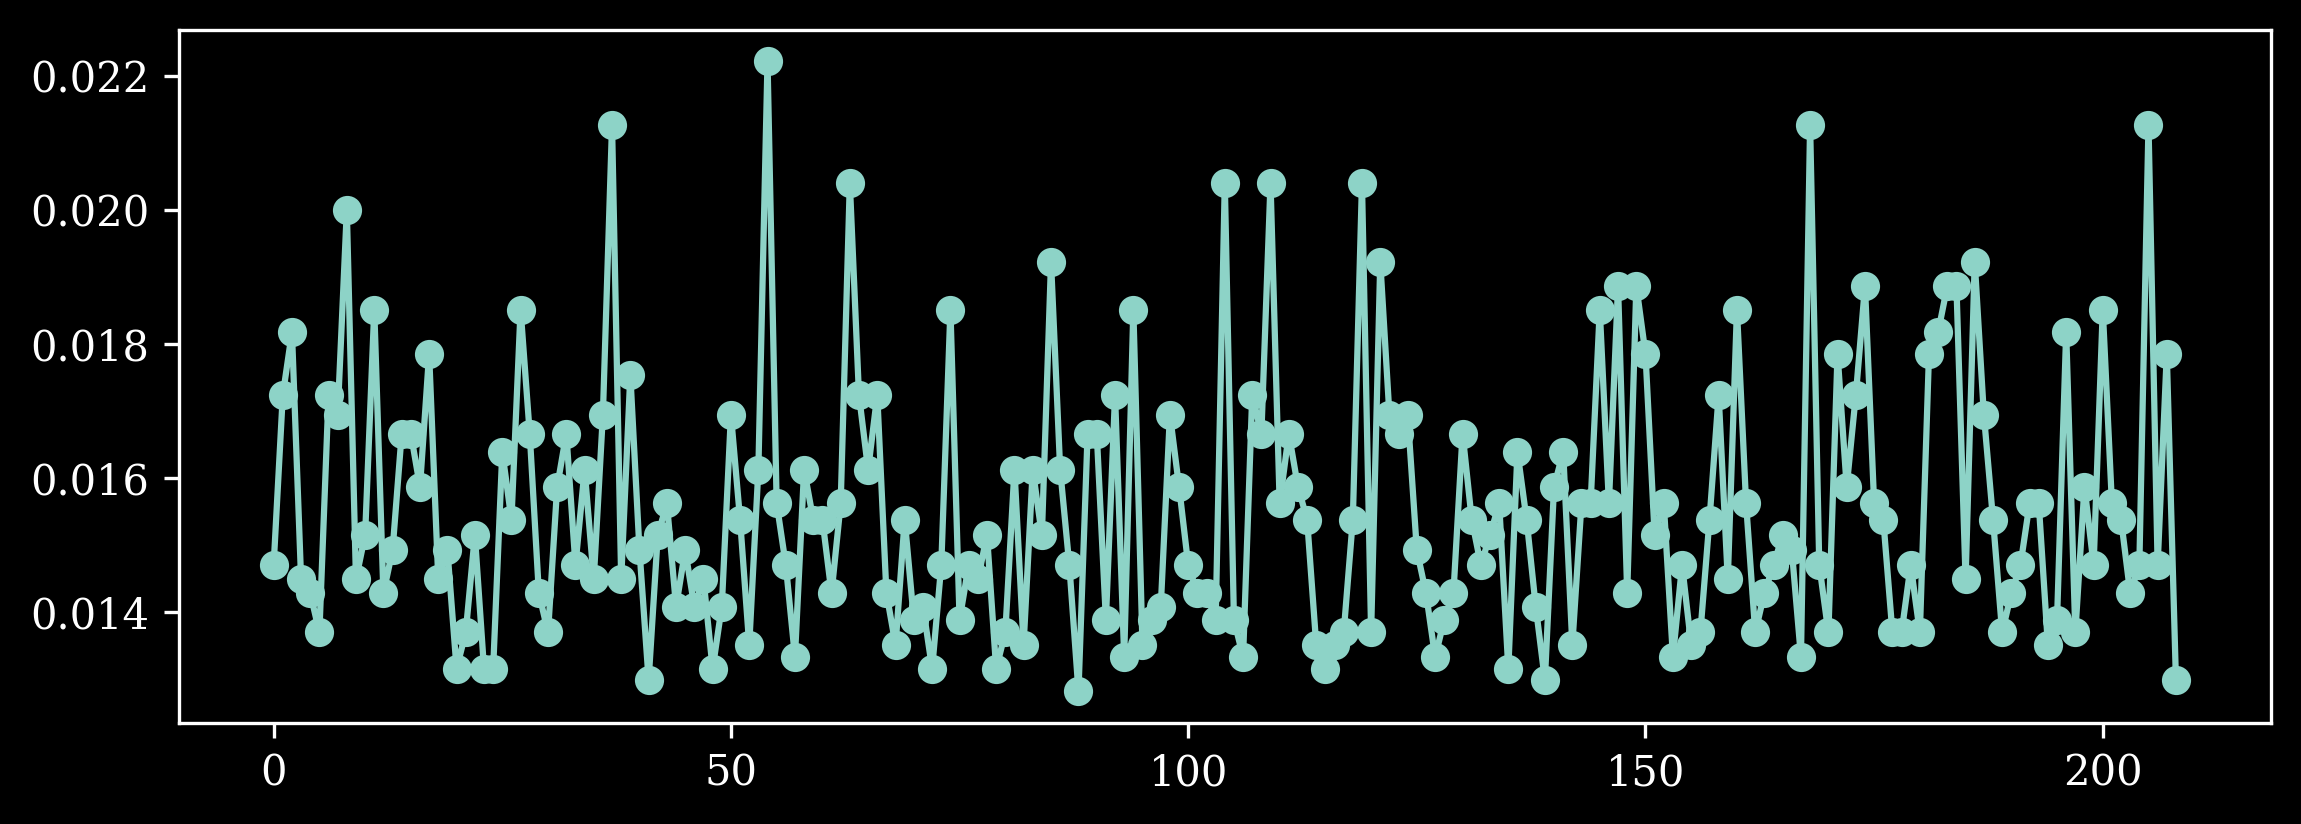

In [31]:
# plot dt for train
plt.plot(dtTrain, marker='o')

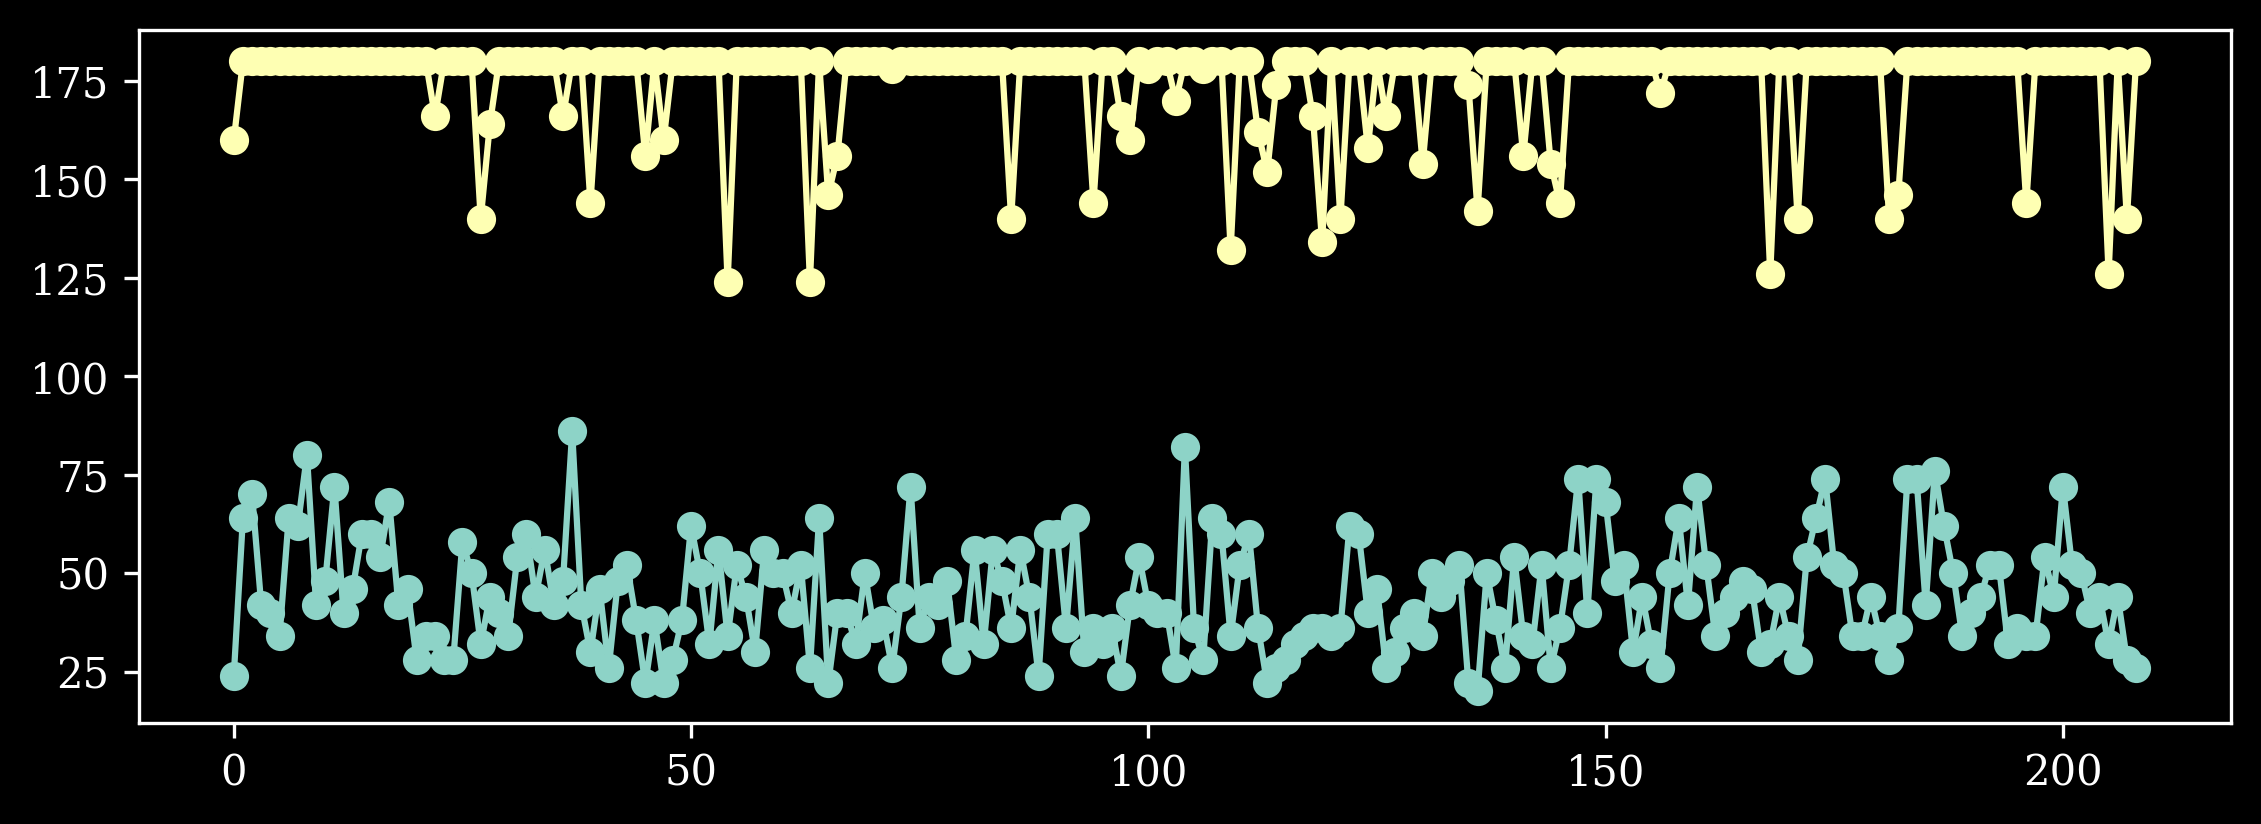

In [32]:
plt.plot(tMinTrain, marker='o')
plt.plot(tMaxTrain, marker='o')

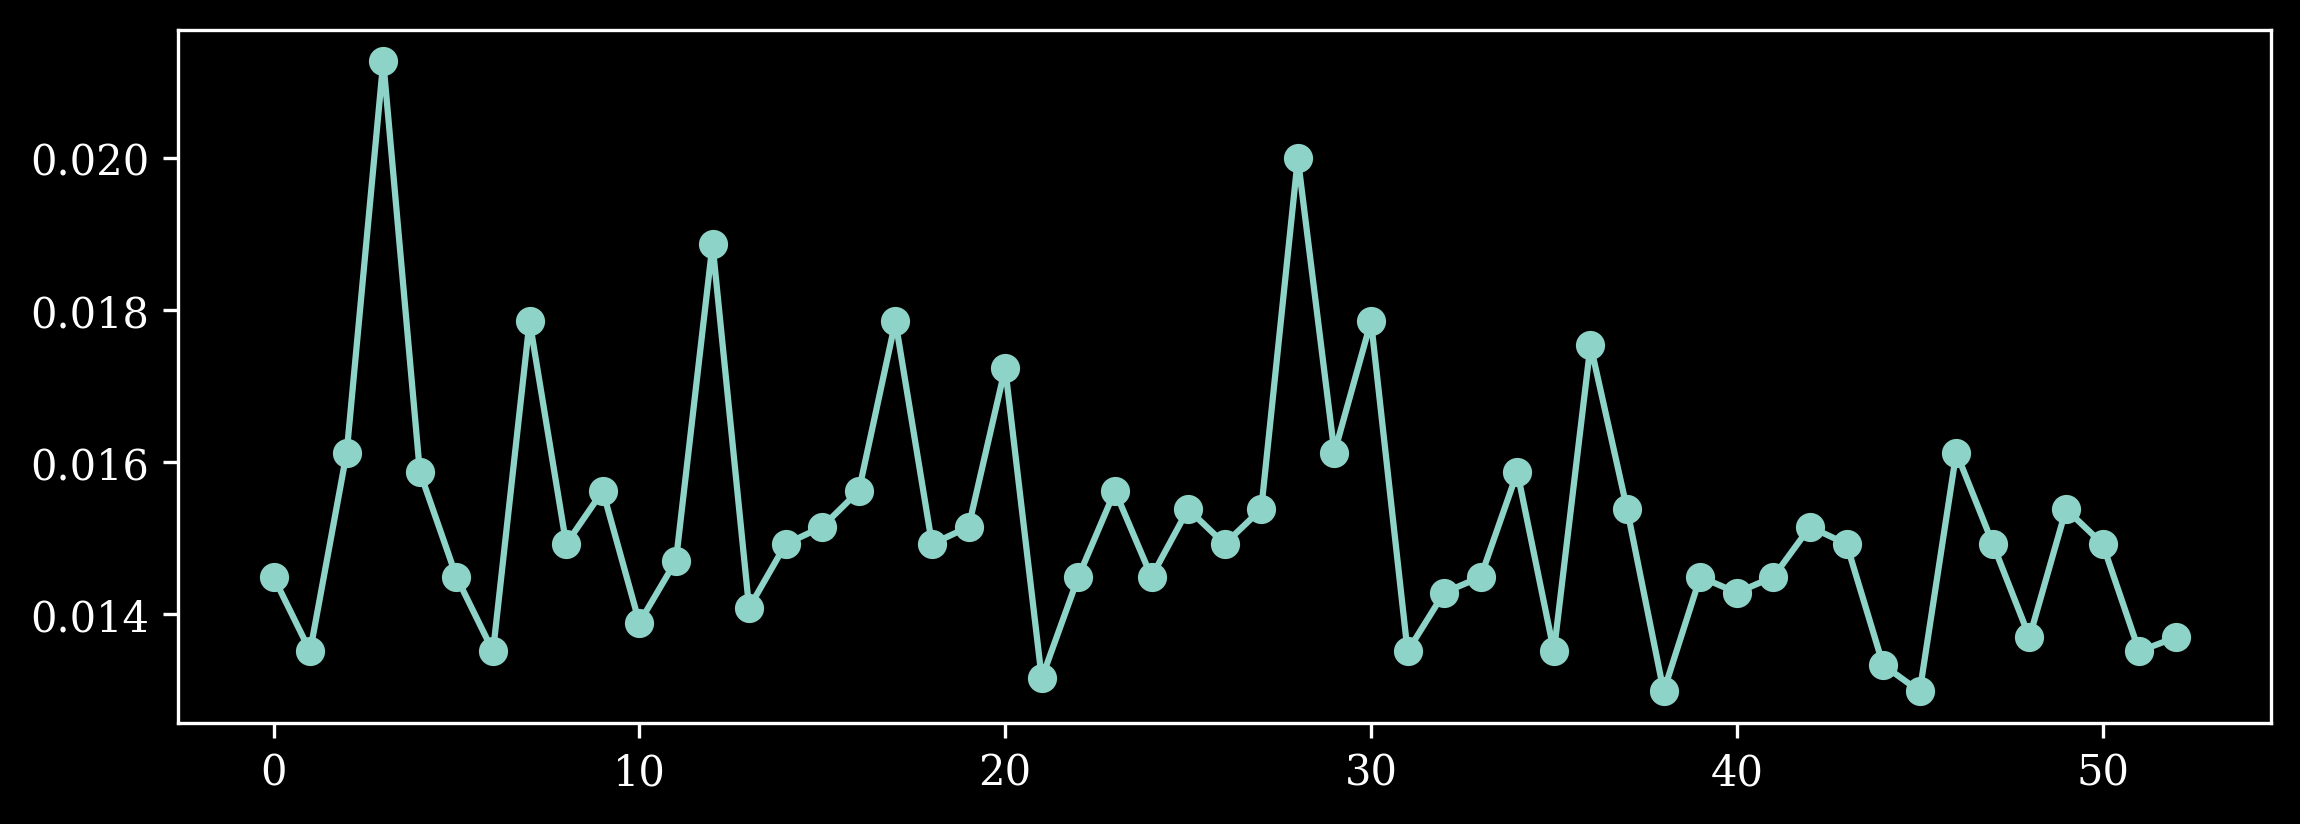

In [33]:
plt.plot(dtTest, marker='o')

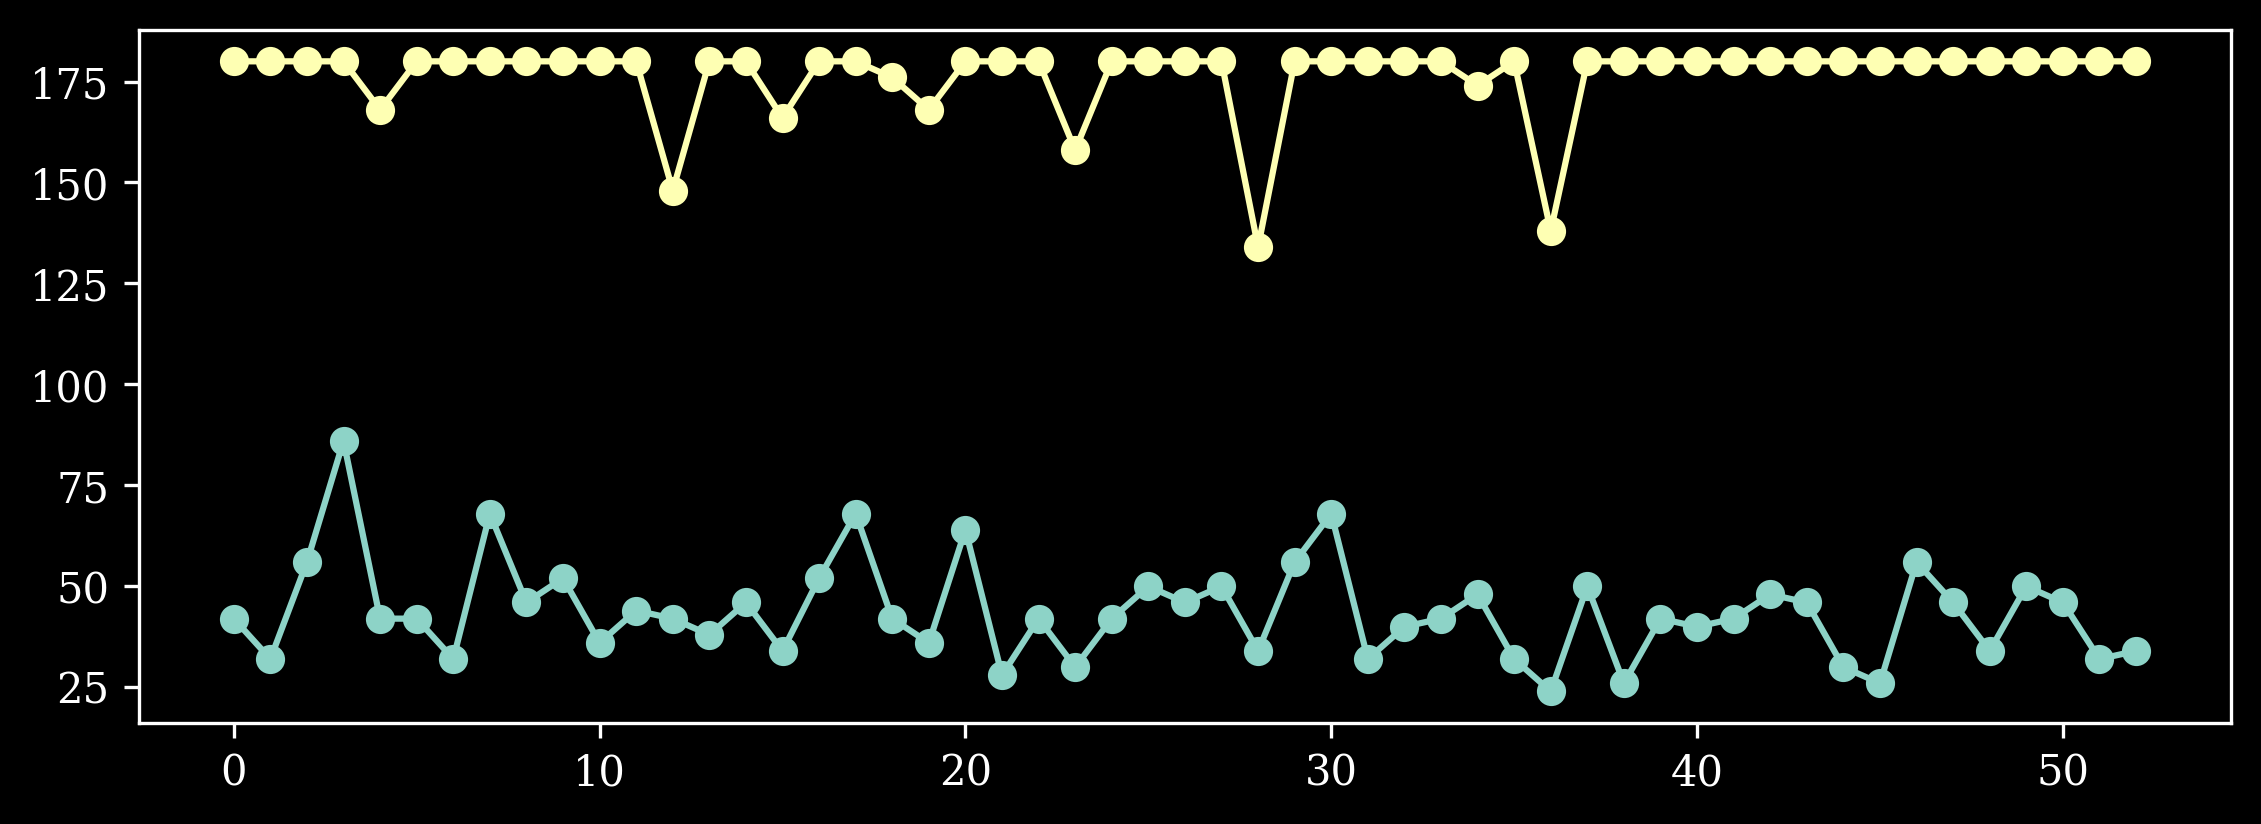

In [34]:
plt.plot(tMinTest, marker='o')
plt.plot(tMaxTest, marker='o')

In [35]:
# NOW NORMALIZE YTRAIN AND YTEST
yMinTrainAll = np.array(yMinTrain).min()
yMaxTrainAll = np.array(yMaxTrain).max()

yMinTrainAll, yMaxTrainAll

(3.765003654922027, 22.764675959009974)

In [36]:
y_train_normalized = (y_train - yMinTrainAll) / (yMaxTrainAll - yMinTrainAll)
y_test_normalized = (y_test - yMinTrainAll) / (yMaxTrainAll - yMinTrainAll)

In [37]:
y_train_normalized.shape

(90, 40, 209)

In [38]:
# plt.figure(figsize=(6, 6))
# plt.axes(projection = 'polar')

# sidx_to_plot = 0

# times0 = np.arange(tMinTrainIdx[sidx_to_plot], 
#                    tMaxTrainIdx[sidx_to_plot] + 1, 
#                    step=1)

# color = iter(plt.cm.jet(np.linspace(0, 1, len(times0))))

# for i in times0[:20]:
#     cc=next(color)
#     plt.plot(theta_grid * np.pi/180, 
#              y_train_normalized[i, :, sidx_to_plot], 
#              c=cc)
    
# plt.title("After normalization")

In [39]:
# plt.figure(figsize=(6, 6))
# plt.axes(projection = 'polar')

# sidx_to_plot = 0

# times0 = np.arange(tMinTrainIdx[sidx_to_plot], 
#                    tMaxTrainIdx[sidx_to_plot] + 1, 
#                    step=1)

# color = iter(plt.cm.jet(np.linspace(0, 1, len(times0))))

# for i in times0[:20]:
#     cc=next(color)
#     plt.plot(theta_grid * np.pi/180, 
#              y_train[i, :, sidx_to_plot], 
#              c=cc)
    
# plt.title("Before normalization")

In [40]:
cme_params_norm = pd.read_csv("./CMEParams2161_Scaled.csv", index_col=0)
cme_params_norm

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506
...,...,...,...,...,...,...,...,...,...
294,0.8750,0.252834,0.622193,0.1750,0.0,0.363636,0.352593,0.005643,0.937194
295,0.1250,0.655648,0.235434,0.4750,0.0,0.363636,0.352593,0.005643,0.937194
296,0.3250,0.518360,0.245710,0.7750,1.0,0.363636,0.352593,0.005643,0.937194
297,0.9250,0.289994,0.829820,0.6750,0.0,0.363636,0.352593,0.005643,0.937194


In [41]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

In [42]:
cme_params_to_augment_final = np.zeros((cme_params_to_augment.shape[0],
                                       cme_params_to_augment.shape[1] + 1))
cme_params_to_augment_final[:, :(cme_params_to_augment.shape[1])] = cme_params_to_augment


cme_params_to_augment_final[orig_sd_train_idx, cme_params_to_augment.shape[1]] = dtTrain
cme_params_to_augment_final[orig_sd_test_idx, cme_params_to_augment.shape[1]] = dtTest

In [43]:
param_dim = cme_params_to_augment_final.shape[1]
param_dim

10

In [44]:
input_dim = rd_2161.shape[1]
input_dim, param_dim

(40, 10)

In [45]:
augmented_r = np.zeros((rd_2161.shape[0], input_dim + param_dim, rd_2161.shape[2]))
augmented_r[:, :input_dim, orig_sd_train_idx] = y_train_normalized
augmented_r[:, :input_dim, orig_sd_test_idx] = y_test_normalized

for iii in range(rd_2161.shape[2]):
    augmented_r[:, (input_dim):, iii] = cme_params_to_augment_final[iii, :]

In [46]:
aug_y_train = augmented_r[:, :, orig_sd_train_idx]
aug_y_test = augmented_r[:, :, orig_sd_test_idx]

aug_y_train.shape, aug_y_test.shape

((90, 50, 209), (90, 50, 53))

In [47]:
class PNODE(nn.Module):
    def __init__(self, input_dim, param_dim, 
                 n_layers=1, 
                 n_units=90,
                 nonlinear=nn.ELU):
        super(PNODE, self).__init__()

        layers = [nn.Linear(input_dim + param_dim, n_units)]
        
        for i in range(n_layers - 1):
            layers.append(nonlinear())
            layers.append(nn.Linear(n_units, n_units))
            
        layers.append(nonlinear())
        layers.append(nn.Linear(n_units, input_dim))
        
        self.net1 = nn.Sequential(*layers)
        
        # for m in self.net1.modules():
        #     if isinstance(m, nn.Linear):
        #         nn.init.normal_(m.weight, mean=0, std=0.1)
        #         nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        
        output = torch.cat((self.net1(y),
                    torch.zeros_like(y[:, input_dim:])), 
                    -1)
        
        return output

In [48]:
model = PNODE(input_dim,
              param_dim,
              n_layers=args.node_layers,
              n_units=args.units,
              nonlinear=nn.ELU).to(device)

optimizer = optim.Adam(model.parameters(), lr=args.lr)

print(args.lr)

print(edut.count_parameters(model))

print(model)

edut.makedirs(args.save)

if args.load is not None:
    experimentID = args.load
else:
    experimentID = int(SystemRandom().random()*100000)
print(experimentID)

ckpt_path = os.path.join(args.save, "experiment_" + str(experimentID) + '.ckpt')
print(ckpt_path)

0.001
19240
PNODE(
  (net1): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=100, out_features=40, bias=True)
  )
)
30669
experiments/experiment_30669.ckpt


In [49]:
def get_batch_sim(torch_train_data, 
              torch_train_time, 
              # sim_ids = [0, 1, 2, 3, 4], 
              batch_time=4, 
              batch_size=5):
    # by0 = []
    # bt = []
    # by = []
    # s_all = []
    # for sim in sim_ids:
    
    s = torch.from_numpy(np.random.choice(np.arange(len(torch_train_time) - batch_time, dtype=np.int64),
                                          batch_size,
                                          replace=False))
    # batch_y0 = torch_train_data[s, :, sim]  # (M, D)
    
    batch_y0 = torch_train_data[s]  # (M, D)
    # print(batch_y0.shape)
    
    
    batch_t = torch.zeros((batch_size, batch_time))
    for i in range(batch_size):
        batch_t[i, :] = torch_train_time[s[i]:(s[i] + batch_time)]

    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)

    # by0.append(batch_y0)
    # bt.append(batch_t)
    # by.append(batch_y)
    # # s_all.append(s)
        
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)
    # return torch.stack(by0, dim=0).to(device), torch.stack(bt, dim=0).to(device), torch.stack(by,dim=0).to(device), s_all
    # return torch.stack(by0, dim=0).to(device), torch.stack(bt, dim=0).to(device), torch.stack(by,dim=0).to(device)

In [50]:
def get_data_for_sim(sidx, device="cpu"):
    """
    Supply sidx from either orig_sd_train_idx or orig_sd_test_idx
    Based on that, index augmented r dataset, and return relevant training data
    as well as training time.
    """
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = sidx)
    
    valid_times = np.arange(tMin, tMax + 2, step=2)
        
    tAllScaled = (valid_times - tMin) / (tMax - tMin)
    
    r_sim = augmented_r[tMinIdx:(tMaxIdx + 1), :, sidx]
    
    y0_train_torch = torch.from_numpy(np.float32(r_sim[0, :])).reshape((1, len(r_sim[0, :]))).to(device)
    
    t_train_torch = torch.tensor(np.float32(tAllScaled)).to(device)
    
    y_train_torch = torch.from_numpy(np.float32(r_sim)).to(device)
    

    return y0_train_torch, t_train_torch, y_train_torch

In [51]:
# y0t1, tt1, ytt1 = get_data_for_sim(orig_sd_train_idx[0], device=device)
# by01, bt1, by1 = get_batch_sim(ytt1, tt1, batch_size=args.batch_size, batch_time=args.batch_time)

# y0t2, tt2, ytt2 = get_data_for_sim(orig_sd_train_idx[2], device=device)
# by02, bt2, by2 = get_batch_sim(ytt2, tt2, batch_size=args.batch_size, batch_time=args.batch_time)

# by0_combined = torch.stack([by01, by02], dim=0)
# bt_combined = torch.stack([bt1, bt2], dim=0)
# by_combined = torch.stack([by1, by2], dim=0)

# print(by0_combined.shape, bt_combined.shape, by_combined.shape)

# print(model.net1(by0_combined[:, [5], :]).shape, torch.zeros_like(by0_combined[:, [5], input_dim:]).shape)
# print(torch.cat((model.net1(by0_combined[:, [5], :]),
#          torch.zeros_like(by0_combined[:, [5], input_dim:])),
#          -1).shape)
# # model.forward(torch.tensor(0.5), by0_combined[0, [5], :])
# # bt_combined[0, 5, :]
# # odeint(model, by0_combined[0, [5], :], bt_combined[0, 5, :])[:, 0, input_dim:]
# # model(0.2, by0_combined[:, [4], :]).shape

In [52]:
# # TRAIN 2 SIMS ONLY.

# batch_time=4
# batch_size=5
# sim_ids_to_train = [0, 2]

# best_loss = 1e20
# test_freq = 5

# if args.load is not None:
#     ut.get_ckpt_model(ckpt_path, model, device)
# else:
    
#     # get data for sim
#     # y0t = []
#     tt = []
#     ytt = []
#     for i in sim_ids_to_train:
#         _, tt_data, ytt_data = get_data_for_sim(orig_sd_train_idx[i], device=device)
#         # y0t.append(y0_data)
#         tt.append(tt_data)
#         ytt.append(ytt_data)
#         # print("Training data created")
#     for itr in range(1, args.niters + 1):
#         optimizer.zero_grad()

#         by0 = []
#         bt = []
#         byt = []
#         for i, idx in enumerate(sim_ids_to_train):
#             by0_data, bt_data, byt_data = get_batch_sim(ytt[i], 
#                                                         tt[i],
#                                                         batch_time=batch_time,
#                                                         batch_size=batch_size)
#             by0.append(by0_data)
#             bt.append(bt_data)
#             byt.append(byt_data)
            
#         batch_y0 = torch.stack(by0, dim=0)
#         batch_t = torch.stack(bt, dim=0)
#         batch_y = torch.stack(byt, dim=0)
        
#         # print(batch_y0.shape, batch_t.shape, batch_y.shape)
        
#         # stack everything

#         # two loops. outer by sim and inner by batch_size
#         # the timesteps to integrate for are different for different ICs, hence needed
#         # else we can just do odeint on the entire tensor at once.

#         # Predict batch_y and get mean absolute error loss.
#         pred_y = torch.zeros_like(batch_y).to(device)

#         for sim_idx, sim in enumerate(sim_ids_to_train):
#             for i in range(batch_size):
#                 pred_y[sim_idx, :, i, :] = torch.squeeze(odeint(model,
#                                                             batch_y0[sim_idx, [i], :],
#                                                             batch_t[sim_idx, i, :]))

#         loss = torch.mean(torch.abs(pred_y - batch_y))
        
#         # print(loss.item())
#         loss.backward()

#         optimizer.step()

#         if itr % test_freq == 0:
#             bsave = False
#             with torch.no_grad():
                
#                 train_losses = []
                
#                 for sim_idx, sim in enumerate(sim_ids_to_train):
#                     pred_y_train = torch.squeeze(odeint(model,
#                                                         ytt[sim_idx][[0], :],
#                                                         tt[sim_idx]))
                    
#                     train_losses.append(torch.mean(torch.abs(pred_y_train - \
#                                                 ytt[sim_idx])))



#                 message = "Iteration {:04d} | Train loss Sim 1 {:6f} | Train loss Sim 2 {:6f} | Train loss (one batch) {:.6f}|".format(
#                     itr, 
#                     train_losses[0].item(),
#                     train_losses[1].item(),
#                     loss.item())
                
#                 print(message)

#         if itr % 500 == 0:
#             bsave = True
#             if bsave:
#                 print('saving check point...')
#                 torch.save({
#                     'args': args,
#                     'state_dict': model.state_dict(),
#                 }, ckpt_path)

#     if bsave:
#         torch.save({
#             'args': args,
#             'state_dict': model.state_dict(),
#         }, ckpt_path)

In [53]:
### RESULTS OF TRAIN 2 SIMS.
# with torch.no_grad():

#     # yMinTrainAll, yMaxTrainAll
    
#     pred_y_train_1 = torch.squeeze(odeint(model,
#                                         ytt[0][[0], :],
#                                         tt[0])) * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll
    
#     pred_y_train_2 = torch.squeeze(odeint(model,
#                                         ytt[1][[0], :],
#                                         tt[1])) * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

    
# print(orig_sd_train_idx[sim_ids_to_train])

# tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = orig_sd_train_idx[0])
# r_true_train_1 = augmented_r[tMinIdx:(tMaxIdx + 1), :input_dim, orig_sd_train_idx[0]]

# edut.plotTrainPredData1Model(r_true_train_1 * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll,
#                              pred_y_train_1.cpu()[:, :input_dim],
#                              ed_2161,
#                              sd_2161,
#                              theta=theta_grid,
#                              simIdx=orig_sd_train_idx[sim_ids_to_train[0]],
#                              savefig=False)

# tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = orig_sd_train_idx[2])
# r_true_train_2 = augmented_r[tMinIdx:(tMaxIdx + 1), :input_dim, orig_sd_train_idx[2]]

# edut.plotTrainPredData1Model(r_true_train_2 * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll,
#                              pred_y_train_2.cpu()[:, :input_dim],
#                              ed_2161,
#                              sd_2161,
#                              theta=theta_grid,
#                              simIdx=orig_sd_train_idx[sim_ids_to_train[1]],
#                              savefig=False)

#### Set up training for multiple sims based on defined args.

We will go for more aggressive batch size and batch times. Its better to have 5 representative simulations as validation checks. So the batch in the optimization can keep changing, but we can keep tracking validation loss aggregated over select sims, and we can see if its showing a downward trend.

In [54]:
# from sklearn.utils import shuffle

In [55]:
# # rough estimate of frequency of each sim in np sort 
# sim_ids_all = np.array([i for i in range(len(orig_sd_train_idx))])
# sims_visited = np.array([])
# for i in range(170):
#     sims_visited = np.append(sims_visited, np.sort(rng.choice(sim_ids_all, args.nsims_per_batch, replace=False)))
    
# unique_sims, counts = np.unique(sims_visited, return_counts=True)

# print(len(unique_sims))

# plt.hist(sims_visited, bins=len(sim_ids_all));

In [56]:
batch_time=args.batch_time
batch_size=args.batch_size
# sim_ids_to_train = [0, 2]
sim_ids_all = np.array([i for i in range(len(orig_sd_train_idx))])
sim_ids_to_track = [0, 1, 2, 3, 4]
best_loss = 1e20
test_freq = 5
ckpt_freq = 500

train_batch_losses = []
val_sim_losses_agg = []
val_sim_losses_ind = []


tt_val = []
ytt_val = []
for i in sim_ids_to_track:
    _, tt_data, ytt_data = get_data_for_sim(orig_sd_track_idx[i], device=device)
    # y0t.append(y0_data)
    tt_val.append(tt_data)
    ytt_val.append(ytt_data)


if args.load is not None:
    ut.get_ckpt_model(ckpt_path, model, device)
else:
    for ep in range(1, args.nepochs + 1):
        sim_ids_to_train = np.sort(rng.choice(sim_ids_all, args.nsims_per_batch, replace=False))
        tt = []
        ytt = []
        for i in sim_ids_to_train:
            _, tt_data, ytt_data = get_data_for_sim(orig_sd_train_idx[i], device=device)
            # y0t.append(y0_data)
            tt.append(tt_data)
            ytt.append(ytt_data)

        for itr in range(1, args.niters + 1):
            optimizer.zero_grad()

            by0 = []
            bt = []
            byt = []
            for i, idx in enumerate(sim_ids_to_train):
                by0_data, bt_data, byt_data = get_batch_sim(ytt[i], 
                                                            tt[i],
                                                            batch_time=batch_time,
                                                            batch_size=batch_size)
                by0.append(by0_data)
                bt.append(bt_data)
                byt.append(byt_data)

            batch_y0 = torch.stack(by0, dim=0)
            batch_t = torch.stack(bt, dim=0)
            batch_y = torch.stack(byt, dim=0)

            # print(batch_y0.shape, batch_t.shape, batch_y.shape)

            # stack everything

            # two loops. outer by sim and inner by batch_size
            # the timesteps to integrate for are different for different ICs, hence needed
            # else we can just do odeint on the entire tensor at once.

            # Predict batch_y and get mean absolute error loss.
            pred_y = torch.zeros_like(batch_y).to(device)

            for sim_idx, sim in enumerate(sim_ids_to_train):
                for i in range(batch_size):
                    pred_y[sim_idx, :, i, :] = torch.squeeze(odeint(model,
                                                                batch_y0[sim_idx, [i], :],
                                                                batch_t[sim_idx, i, :]))

            loss = torch.mean(torch.abs(pred_y - batch_y))

            loss.backward()
            optimizer.step()

            train_batch_losses.append(loss.item())

            if itr % test_freq == 0:
                bsave = False
                with torch.no_grad():

                    val_losses_test = []

                    for sim_idx, sim in enumerate(sim_ids_to_track):
                        pred_y_val = torch.squeeze(odeint(model,
                                                        ytt_val[sim_idx][[0], :],
                                                        tt_val[sim_idx]))

                        val_losses_test.append((torch.mean(torch.abs(pred_y_val - \
                                                    ytt_val[sim_idx]))).item())
                    
                    
                    val_losses_aggregate = np.sum(val_losses_test)
                    val_sim_losses_agg.append(val_losses_aggregate)
                    
                    val_sim_losses_ind.append(val_losses_test)

                    message = "Epoch {:02d} | Iteration {:03d} | Val Losses Aggregate {:.6f} | Train loss (one batch) {:.6f}|".format(
                        ep,
                        itr, 
                        val_losses_aggregate,
                        loss.item())

                    print(message)

            if itr % ckpt_freq == 0:
                bsave = True
                if bsave:
                    print('saving check point...')
                    torch.save({
                        'args': args,
                        'state_dict': model.state_dict(),
                    }, ckpt_path)

Epoch 01 | Iteration 005 | Val Losses Aggregate 1.041579 | Train loss (one batch) 0.022542|
Epoch 01 | Iteration 010 | Val Losses Aggregate 0.732898 | Train loss (one batch) 0.015544|
Epoch 01 | Iteration 015 | Val Losses Aggregate 0.492965 | Train loss (one batch) 0.012618|


KeyboardInterrupt: 